In [1]:
import tensorflow as tf
import pandas as pd
import transformers
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [2]:
df = pd.read_csv("../Datasets/newsdata.csv", names = ["Category", "Text"])
df.head()

,Category,Text
0,Crypto,Would You Shop at Tesla Using Dogecoin?
1,Crypto,Conmen made $1.3 bn via romance scams in 5 yea...
2,Crypto,Bitcoin paradise? Briton creates crypto utopia...
3,Crypto,Intel Launches Blockchain Chip To Tap Crypto Boom
4,Crypto,OpenSea's NFT Free-for-All


In [3]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,Category,Text
83,Tech,Apple Said to Raise Salary of Its US Employees...
115,Tech,Google Search reveals jobs people want amid Co...
31,Oil,Oil Prices Spike On Rumors Russia Is Preparing...
36,Oil,Rupee slumps 31 paise to 75.46 against US doll...
60,Gaming,Nintendo Hacker Gary Bowser to spend the next ...


In [4]:
#Category-wise data point counts
df["Category"].value_counts()

Tech      33
Gaming    27
Oil       19
Crypto    19
EVs       18
Name: Category, dtype: int64

In [5]:
#Length of dataset
df.shape

(116, 2)

In [6]:
df["Category"] = df["Category"].replace({'Crypto': 0, 'Oil': 1, 'EVs': 2, 'Tech': 3, 'Gaming': 4})

#Category-wise data point counts
df["Category"].value_counts()

3    33
4    27
1    19
0    19
2    18
Name: Category, dtype: int64

In [7]:
e_df = pd.get_dummies(df, columns=["Category"])

e_df.head()

,Text,Category_0,Category_1,Category_2,Category_3,Category_4
83,Apple Said to Raise Salary of Its US Employees...,0,0,0,1,0
115,Google Search reveals jobs people want amid Co...,0,0,0,1,0
31,Oil Prices Spike On Rumors Russia Is Preparing...,0,1,0,0,0
36,Rupee slumps 31 paise to 75.46 against US doll...,0,1,0,0,0
60,Nintendo Hacker Gary Bowser to spend the next ...,0,0,0,0,1


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(e_df["Text"], e_df.iloc[:,1:], random_state = 0,
                                                   test_size = 0.2)

In [9]:
x_train.head()

80     Apex Legends Season 12 Accidentally Gives Some...
84     Romance scams cost Americans over $500 million...
105    Samsung Galaxy S22 Ultra  6 reasons to buy and...
45     Ohio Can Lead The Electric Vehicle & Clean Ene...
86     Android Circuit: Samsungs Galaxy S22 Surprise,...
Name: Text, dtype: object

In [10]:
y_train.head()

,Category_0,Category_1,Category_2,Category_3,Category_4
80,0,0,0,0,1
84,0,0,0,1,0
105,0,0,0,1,0
45,0,0,1,0,0
86,0,0,0,1,0


In [11]:
#Do not re-run multiple times, it downloads the BERT model.

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [12]:
def get_sentence_encoding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    
    return bert_encoder(preprocessed_text)["pooled_output"]

In [13]:
#Model

#BERT Layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = "Text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#NN Layers
l1 = tf.keras.layers.Dropout(0.2, name = "dropout")(outputs["pooled_output"])    #reduce overfitting
l2 = tf.keras.layers.Dense(5, activation="softmax", name="output")(l1)

#Construct the model
model = tf.keras.Model(inputs = [text_input], outputs = [l2])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [15]:
model_metrics = [
    tf.keras.metrics.CategoricalAccuracy(name = "categorical_accuracy"),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name = "recall")
]

model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = model_metrics)

In [16]:
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
3/3 [==============================] - 23s 5s/step - loss: 1.9265 - categorical_accuracy: 0.1522 - precision: 0.2000 - recall: 0.0217
Epoch 2/50
3/3 [==============================] - 14s 5s/step - loss: 1.7052 - categorical_accuracy: 0.2935 - precision: 0.3636 - recall: 0.0435
Epoch 3/50
3/3 [==============================] - 14s 5s/step - loss: 1.6968 - categorical_accuracy: 0.2500 - precision: 0.2500 - recall: 0.0217
Epoch 4/50
3/3 [==============================] - 14s 5s/step - loss: 1.6725 - categorical_accuracy: 0.2391 - precision: 0.1818 - recall: 0.0217
Epoch 5/50
3/3 [==============================] - 14s 5s/step - loss: 1.6542 - categorical_accuracy: 0.2283 - precision: 0.6667 - recall: 0.0217
Epoch 6/50
3/3 [==============================] - 14s 5s/step - loss: 1.6038 - categorical_accuracy: 0.2609 - precision: 0.5000 - recall: 0.0217   
Epoch 7/50
3/3 [==============================] - 15s 5s/step - loss: 1.6533 - categorical_accuracy: 0.2500 - precision: 0.5000

In [17]:
y_pred = model.predict(x_test)

In [18]:
y_test_maxes = []
y_pred_maxes = []

for pred in y_pred:
    y_pred_maxes.append(np.argmax(pred))

y_test_maxes = y_test.iloc[:, 1:].idxmax(axis=1)

y_test_maxes = y_test_maxes.replace({"Category_0": 0, "Category_1": 1,
                     "Category_2": 2, "Category_3": 3,
                     "Category_4": 4})

y_test_maxes = y_test_maxes.values

print(y_test_maxes, y_pred_maxes, sep = "\n")

[3 3 1 3 1 4 4 4 4 1 1 1 4 3 1 3 1 3 1 2 1 2 3 1]
[4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 3, 3, 2, 4, 3, 4, 3]


Text(33.0, 0.5, 'Ground Truth')

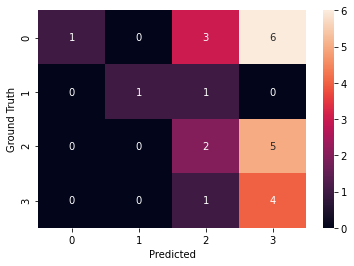

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_maxes, y_pred_maxes)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

In [20]:
print(classification_report(y_test_maxes, y_pred_maxes))

              precision    recall  f1-score   support

           1       1.00      0.10      0.18        10
           2       1.00      0.50      0.67         2
           3       0.29      0.29      0.29         7
           4       0.27      0.80      0.40         5

    accuracy                           0.33        24
   macro avg       0.64      0.42      0.38        24
weighted avg       0.64      0.33      0.30        24

